In [113]:
specific = True

folder_path = "clean_loop/no_mod"
if specific:
    specific_path = "privacy/no_mod_80"

save = True

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors

In [115]:
files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]
dfs = []

for file in files:
    filename = os.path.splitext(file)[0]  # remove .csv
    parts = filename.split('_')
    if len(parts) >= 3:
        algorithm = parts[0]
        dataset = parts[1]
    else:
        continue  # skip if filename doesn't match pattern

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    df['algorithm'] = algorithm.upper()
    df['dataset'] = dataset

    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

In [116]:
if specific:
    folder_path = specific_path

    files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]

    dfs = []

    for file in files:
        filename = os.path.splitext(file)[0]  # remove .csv
        parts = filename.split('_')
        if len(parts) >= 3:
            algorithm = parts[0]
            dataset = parts[1]
        else:
            continue  # skip if filename doesn't match pattern

        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        df['algorithm'] = algorithm.upper()
        df['dataset'] = dataset
        dfs.append(df)

    merged_df_ex = pd.concat(dfs, ignore_index=True)

In [117]:
if not specific:
    metrics_to_plot = ['personalization', 'intra_list_dissimilarity']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'personalization':
            metric = 'Inter-diversity'
        elif metric == 'intra_list_dissimilarity':
            metric = 'Intra-list dissimilarity'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/personalization_intra_list_dissimilarity.png')
    plt.savefig(f'{folder_path}/fig/between_intra_dissimilarity.png')
    plt.show()

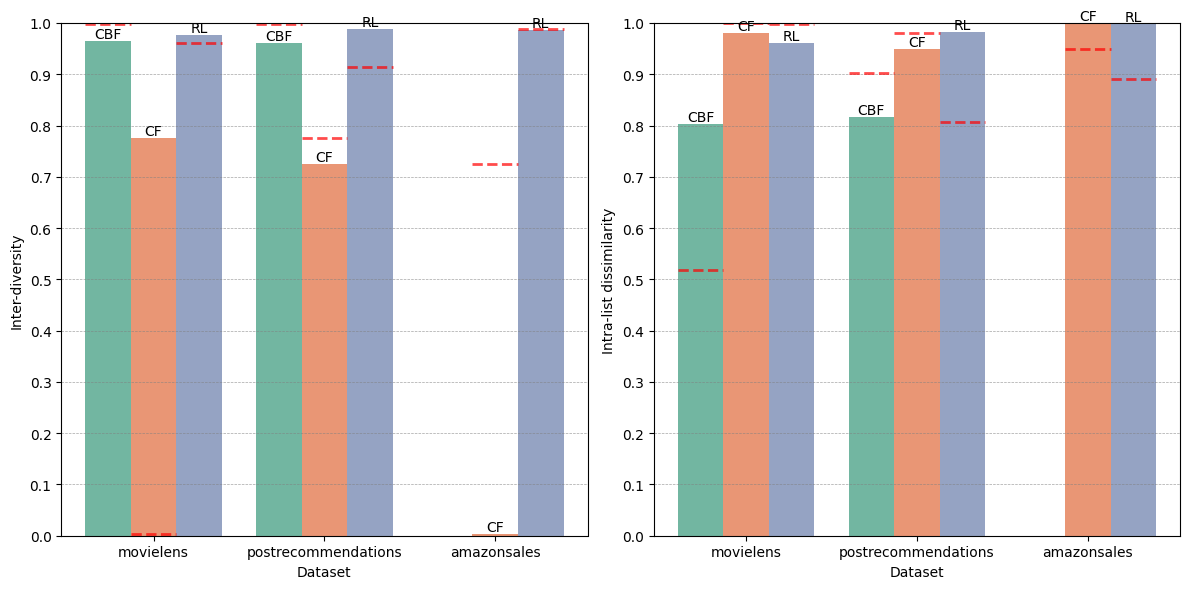

In [118]:
if specific:
    metrics_to_plot = ['personalization', 'intra_list_dissimilarity']

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df_ex[merged_df_ex['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )
        if ax.legend_:
            ax.legend_.remove()  # usuwamy legendę

        df_metric_ref = merged_df[merged_df['key'] == metric]

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            algo = row['algorithm']
            dataset = row['dataset']

            ref_row = df_metric_ref[(df_metric_ref['algorithm'].str.lower() == algo.lower()) & 
                                    (df_metric_ref['dataset'] == dataset)]
            if not ref_row.empty:
                ref_value = ref_row['value'].values[0]

                x_start = p.get_x()
                x_end = p.get_x() + p.get_width()

                ax.hlines(
                    y=ref_value,
                    xmin=x_start,
                    xmax=x_end,
                    colors='red',
                    linestyles='dashed',
                    linewidth=2,
                    alpha=0.7
                )

            height = p.get_height()
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10,
                    color='black'
                )

        if metric == 'personalization':
            metric_label = 'Inter-diversity'
        elif metric == 'intra_list_dissimilarity':
            metric_label = 'Intra-list dissimilarity'
        else:
            metric_label = metric
        ax.set_ylabel(metric_label)
        ax.set_xlabel('Dataset')
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/between_intra_dissimilarity.png')
    plt.show()

In [119]:
if not specific:
    metrics_to_plot = ['item_coverage', 'user_coverage']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'item_coverage':
            metric = 'Item coverage'
        elif metric == 'user_coverage':
            metric = 'User coverage'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/item_user_coverage.png')
    plt.show()

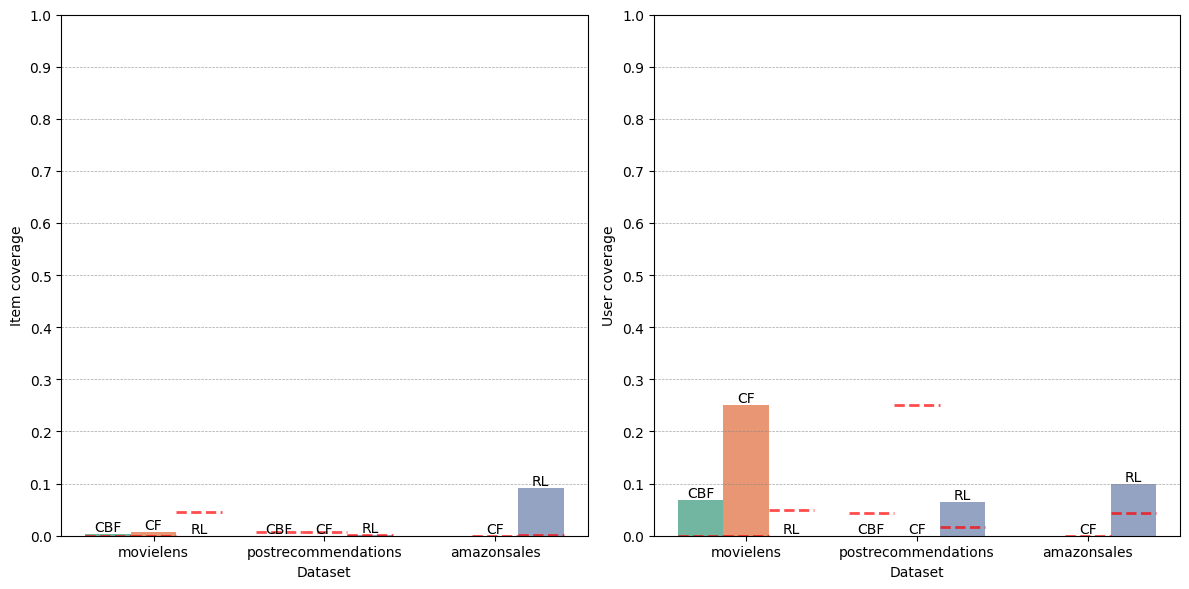

In [120]:
if specific:
    metrics_to_plot = ['item_coverage', 'user_coverage']

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df_ex[merged_df_ex['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )
        if ax.legend_:
            ax.legend_.remove()  # usuwamy legendę

        df_metric_ref = merged_df[merged_df['key'] == metric]

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            algo = row['algorithm']
            dataset = row['dataset']

            ref_row = df_metric_ref[(df_metric_ref['algorithm'].str.lower() == algo.lower()) & 
                                    (df_metric_ref['dataset'] == dataset)]
            if not ref_row.empty:
                ref_value = ref_row['value'].values[0]

                x_start = p.get_x()
                x_end = p.get_x() + p.get_width()

                ax.hlines(
                    y=ref_value,
                    xmin=x_start,
                    xmax=x_end,
                    colors='red',
                    linestyles='dashed',
                    linewidth=2,
                    alpha=0.7
                )

            height = p.get_height()
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10,
                    color='black'
                )

        if metric == 'item_coverage':
            metric_label = 'Item coverage'
        elif metric == 'user_coverage':
            metric_label = 'User coverage'
        else:
            metric_label = metric

        ax.set_ylabel(metric_label)
        ax.set_xlabel('Dataset')
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/item_user_coverage.png')
    plt.show()

In [121]:
if not specific:
    metrics_to_plot = ['mae', 'rmse']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'mae':
            metric = 'MAE'
        elif metric == 'rmse':
            metric = 'RMSE'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mae_rmse.png')
    plt.show()

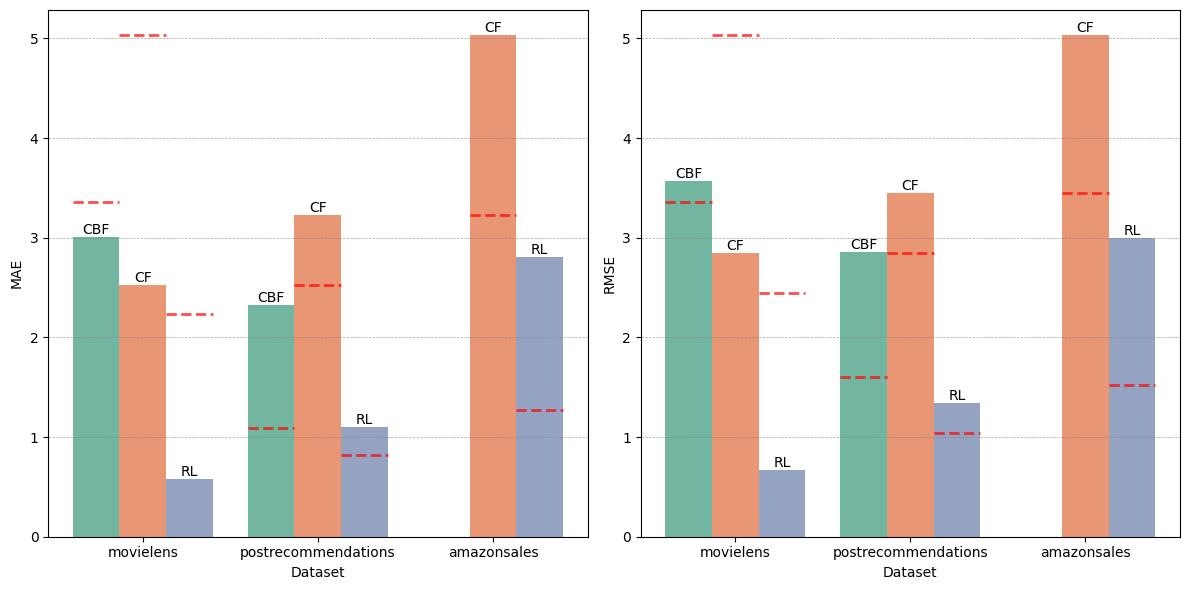

In [122]:
if specific:
    metrics_to_plot = ['mae', 'rmse']

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df_ex[merged_df_ex['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )
        if ax.legend_:
            ax.legend_.remove()  # usuń legendę

        df_metric_ref = merged_df[merged_df['key'] == metric]

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            algo = row['algorithm']
            dataset = row['dataset']

            ref_row = df_metric_ref[(df_metric_ref['algorithm'].str.lower() == algo.lower()) & 
                                    (df_metric_ref['dataset'] == dataset)]
            if not ref_row.empty:
                ref_value = ref_row['value'].values[0]

                x_start = p.get_x()
                x_end = p.get_x() + p.get_width()

                ax.hlines(
                    y=ref_value,
                    xmin=x_start,
                    xmax=x_end,
                    colors='red',
                    linestyles='dashed',
                    linewidth=2,
                    alpha=0.7
                )

            height = p.get_height()
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10,
                    color='black'
                )

        if metric == 'mae':
            metric_label = 'MAE'
        elif metric == 'rmse':
            metric_label = 'RMSE'
        else:
            metric_label = metric

        ax.set_ylabel(metric_label)
        ax.set_xlabel('Dataset')
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mae_rmse.png')
    plt.show()

In [123]:
if not specific:
    metrics_to_plot = ['mrr', 'ndcg_at_k']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        ax.set_ylim(0, 1)
        if metric == 'ndcg_at_k':
            metric='NDCG'
        elif metric == 'mrr':
            metric='MRR'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mrr_ndcg.png')
    plt.show()

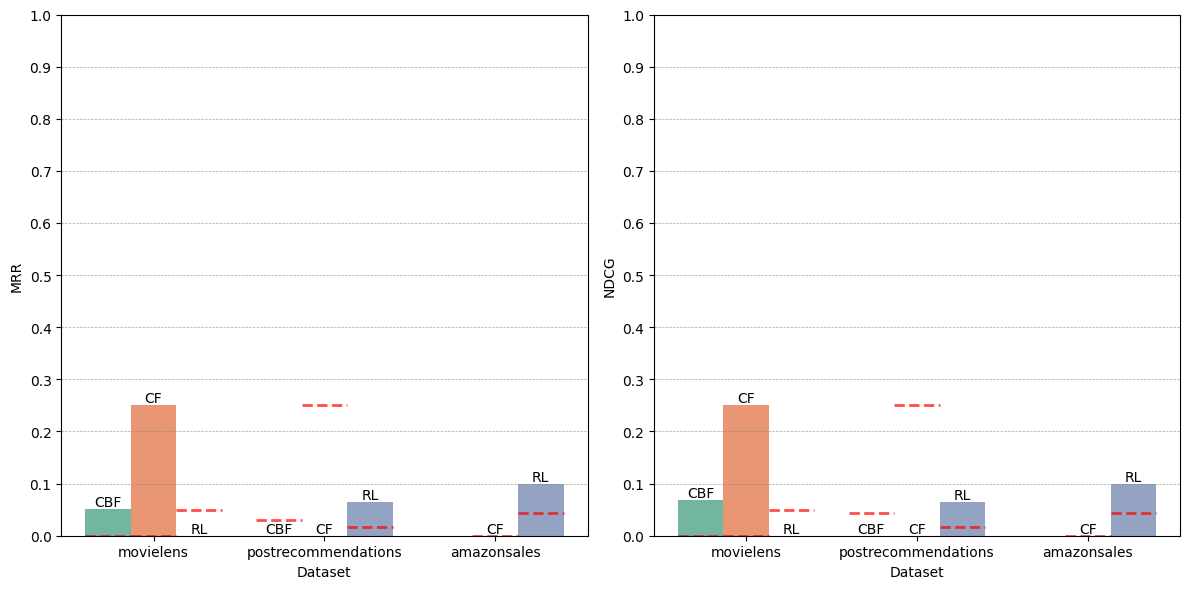

In [124]:
if specific:
    metrics_to_plot = ['mrr', 'ndcg_at_k']

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df_ex[merged_df_ex['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )
        if ax.legend_:
            ax.legend_.remove()

        df_metric_ref = merged_df[merged_df['key'] == metric]

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            algo = row['algorithm']
            dataset = row['dataset']

            ref_row = df_metric_ref[
                (df_metric_ref['algorithm'].str.lower() == algo.lower()) &
                (df_metric_ref['dataset'] == dataset)
            ]
            if not ref_row.empty:
                ref_value = ref_row['value'].values[0]

                x_start = p.get_x()
                x_end = p.get_x() + p.get_width()

                ax.hlines(
                    y=ref_value,
                    xmin=x_start,
                    xmax=x_end,
                    colors='red',
                    linestyles='dashed',
                    linewidth=2,
                    alpha=0.7
                )

            height = p.get_height()
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10,
                    color='black'
                )

        ax.set_ylim(0, 1)

        if metric == 'ndcg_at_k':
            metric_label = 'NDCG'
        elif metric == 'mrr':
            metric_label = 'MRR'
        else:
            metric_label = metric

        ax.set_ylabel(metric_label)
        ax.set_xlabel('Dataset')
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mrr_ndcg.png')
    plt.show()

In [125]:
if not specific:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

    df_precision = merged_df[merged_df['key'] == 'precision']
    df_precision_at_k = merged_df[merged_df['key'] == 'precision_at_k']

    ax = axes[0]
    sns.barplot(
        data=df_precision,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_precision_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Precision')
    ax.set_xlabel('Dataset')
    ax.set_title('Precision')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Recall plot
    df_recall = merged_df[merged_df['key'] == 'recall']
    df_recall_at_k = merged_df[merged_df['key'] == 'recall_at_k']

    ax = axes[1]
    sns.barplot(
        data=df_recall,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_recall_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Recall')
    ax.set_xlabel('Dataset')
    ax.set_title('Recall')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/precision_recall.png')
    plt.show()

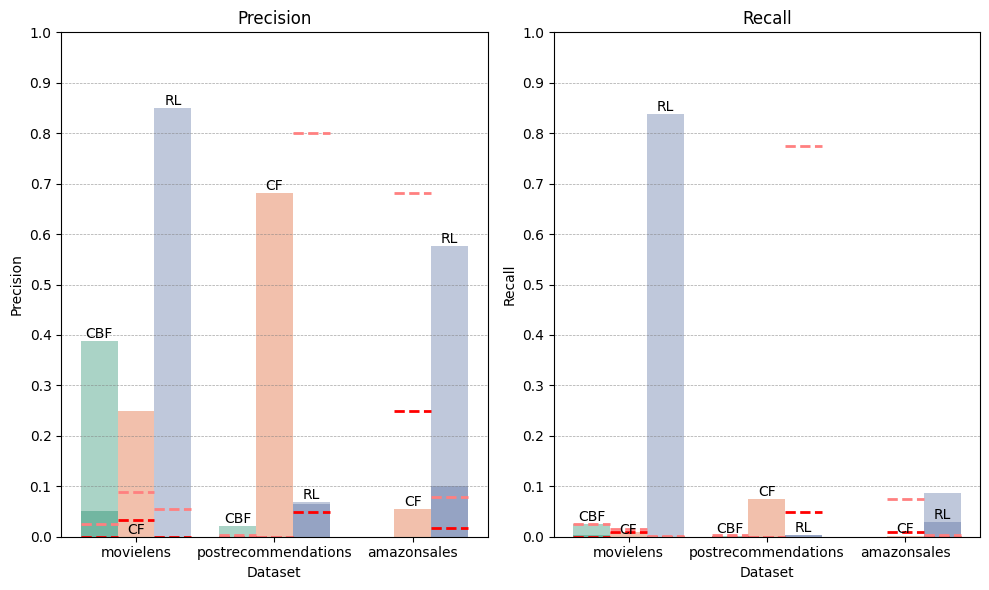

In [126]:
if specific:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

    df_precision_ex = merged_df_ex[merged_df_ex['key'] == 'precision']
    df_precision_at_k_ex = merged_df_ex[merged_df_ex['key'] == 'precision_at_k']

    df_precision = merged_df[merged_df['key'] == 'precision']
    df_precision_at_k = merged_df[merged_df['key'] == 'precision_at_k']

    ax = axes[0]
    sns.barplot(
        data=df_precision_ex,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row_ex), (_, row_old) in zip(ax.patches, df_precision_at_k_ex.iterrows(), df_precision_at_k.iterrows()):
        height_ex = p.get_height()
        algo = row_ex['algorithm']

        base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
        lighter_color = mcolors.to_rgba(base_color)
        lighter_rgb = mcolors.to_rgb(lighter_color[:3])
        lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

        ax.bar(
            p.get_x() + p.get_width() / 2,
            row_ex['value'] - height_ex,
            width=p.get_width(),
            bottom=height_ex,
            align='center',
            color=lighter_rgb,
            edgecolor='none'
        )
        ax.annotate(
            algo,
            (p.get_x() + p.get_width() / 2, row_ex['value']),
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

        base_old = df_precision.loc[
            (df_precision['dataset'] == row_old['dataset']) &
            (df_precision['algorithm'] == row_old['algorithm']),
            'value'
        ].values[0]

        top_old = row_old['value']

        ax.hlines(
            base_old,
            p.get_x(),
            p.get_x() + p.get_width(),
            colors='red',
            linestyles='dashed',
            linewidth=2
        )
        ax.hlines(
            top_old,
            p.get_x(),
            p.get_x() + p.get_width(),
            colors='#FF8080',
            linestyles='dashed',
            linewidth=2
        )

    ax.set_ylabel('Precision')
    ax.set_xlabel('Dataset')
    ax.set_title('Precision')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    df_recall_ex = merged_df_ex[merged_df_ex['key'] == 'recall']
    df_recall_at_k_ex = merged_df_ex[merged_df_ex['key'] == 'recall_at_k']

    df_recall = merged_df[merged_df['key'] == 'recall']
    df_recall_at_k = merged_df[merged_df['key'] == 'recall_at_k']

    ax = axes[1]
    sns.barplot(
        data=df_recall_ex,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row_ex), (_, row_old) in zip(ax.patches, df_recall_at_k_ex.iterrows(), df_recall_at_k.iterrows()):
        height_ex = p.get_height()
        algo = row_ex['algorithm']

        base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
        lighter_color = mcolors.to_rgba(base_color)
        lighter_rgb = mcolors.to_rgb(lighter_color[:3])
        lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

        ax.bar(
            p.get_x() + p.get_width() / 2,
            row_ex['value'] - height_ex,
            width=p.get_width(),
            bottom=height_ex,
            align='center',
            color=lighter_rgb,
            edgecolor='none'
        )
        ax.annotate(
            algo,
            (p.get_x() + p.get_width() / 2, row_ex['value']),
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

        base_old = df_recall.loc[
            (df_recall['dataset'] == row_old['dataset']) &
            (df_recall['algorithm'] == row_old['algorithm']),
            'value'
        ].values[0]

        top_old = row_old['value']

        ax.hlines(
            base_old,
            p.get_x(),
            p.get_x() + p.get_width(),
            colors='red',
            linestyles='dashed',
            linewidth=2
        )
        ax.hlines(
            top_old,
            p.get_x(),
            p.get_x() + p.get_width(),
            colors='#FF8080',
            linestyles='dashed',
            linewidth=2
        )

    ax.set_ylabel('Recall')
    ax.set_xlabel('Dataset')
    ax.set_title('Recall')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/precision_recall.png')
    plt.show()
